In [1]:
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from models.model import ConvModel


In [4]:
model_head = ConvModel(out_dim=10, dataset='CIFAR10')
model_head.backbone.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=128, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(128),
    torch.nn.Linear(in_features=128, out_features=10, bias=True),
)
model_head.backbone.requires_grad_(False)
model_head.backbone.fc.requires_grad_(True)
model_head.load_state_dict(torch.load('saved_models/head_training/head_cifar10.pth'))

<All keys matched successfully>

In [8]:
batch_size: int = 1024

In [9]:
test_dataset = datasets.CIFAR10('./datasets', download=True, train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [10]:
correct, numel = 0, 0
loss_fn = torch.nn.CrossEntropyLoss()
logs: dict = {
    "test_loss": [],
    "test_accuracy": []
}

for _ in range(10):
    with torch.no_grad():
        for x_test, y_test in test_loader:
            output = model_head(x_test)
            y_pred = torch.argmax(output, dim=1)
            correct += torch.sum(y_pred == y_test).item()
            numel += batch_size
            loss = loss_fn(output, y_test)
            logs['test_loss'].append(loss.item())
            logs['test_accuracy'].append(correct / numel)

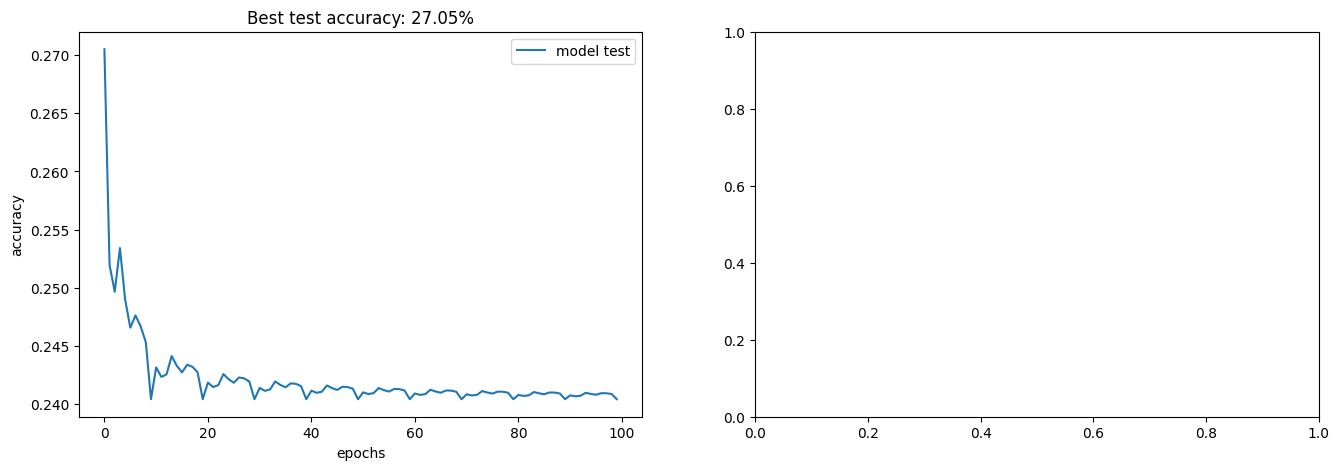

In [11]:
def show_results(orientation='horizontal', accuracy_bottom=None, loss_top=None, **histories):
    if orientation == 'horizontal':
        f, ax = plt.subplots(1, 2, figsize=(16, 5))
    else:
        f, ax = plt.subplots(2, 1, figsize=(16, 16))
    for i, (name, h) in enumerate(histories.items()):
        if len(histories) == 1:
            ax[0].set_title("Best test accuracy: {:.2f}%".format(
                max(h['test_accuracy']) * 100,
            ))
        else:
            ax[0].set_title("Accuracy")
        ax[0].plot(h['test_accuracy'], color='C%s' % i, label='%s test' % name)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('accuracy')
        if accuracy_bottom:
            ax[0].set_ylim(bottom=accuracy_bottom)
        ax[0].legend()

show_results(model=logs)